# Part 2: PVC Influence on mean flow field

In this part, we will add an average flow field to the [synthesized flow fields with PVC vortices](pvc_p1) from the previous chapter. Once again, some patch work will be necessary to create an "authentic"-looking mean flow field as commonly found in swirl-stabilized combustors (that matches the geometric dimension of the PVC vortices). To achieve this, we will stack 1-D Gaussian profiles to create 2-D fields for both velocity components.

## Re-create PVC vortices

The following are the codes we used previously to create the zig-zagging vortices:

In [1]:
# HIDE CODE
import numpy as np
import matplotlib.pyplot as plt


def phantomGaussian(size, fwhm=3, center=None, scale=1, offset_x=0):
    """Create a Gaussian shape inside a rectangle"""
    x = np.arange(0, size, 1, float)
    R = size // 2
    y = x[:R, np.newaxis]

    if center is None:
        x0 = y0 = R
    else:
        x0 = center[0]
        y0 = center[1]
    output = np.exp(-4*np.log(2) * ((x-x0/scale-offset_x)**2 + (y-y0/scale)**2) / (fwhm/scale)**2)

    return output


def pvc_1(size=120, R=60, fac_x=0.951662, fac_y=0.9222):
    """Create a precessing vortex core with spatial shift"""
    
    v_x_settings = [[-0.7, 35, 0, 0],
                    [-0.4, 20, 30, -2], [-0.4, 20, -30, -2],
                    [1.1, 32, 26, 28], [1.1, 32, -26, 28],
                    [0.4, 18, 48, 28], [0.4, 18, -48, 28],
                    [-0.6, 30, 50, 54], [-0.8, 30, 30, 48], [-0.6, 30, -50, 54], [-0.8, 30, -30, 48]]
    v_x_settings = np.array(v_x_settings)
    v_x_settings[:,2] = v_x_settings[:,2]*fac_x
    v_x_settings[:,3] = v_x_settings[:,3]*fac_x
    v_x = np.zeros([R, size])
    for i in v_x_settings:
        v_x += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])

    v_y_settings = [[1., 30, 6, 0], [-1., 30, -6, 0], [0.5, 15, 3, 0], [-0.5, 15, -3, 0],
                    [-0.3, 10, 30, 2], [0.3, 10, -30, 2], [-0.5, 10, 30, 12], [0.5, 10, -30, 12],
                    [-1, 30, 25, 40], [1, 30, -25, 40],
                    [0.8, 35, 40, 70], [-0.8, 35, -40, 70],
                    [0.7, 10, 46, 35], [-0.7, 10, -46, 35],
                    [0.3, 10, 43, 20], [-0.3, 10, -43, 20],
                    [-0.1, 30, 60, 10], [0.1, 30, -60, 10]]
    v_y_settings = np.array(v_y_settings)
    v_y_settings[:,2] = v_y_settings[:,2]*fac_y
    v_y_settings[:,3] = v_y_settings[:,3]*fac_y
    v_y = np.zeros([R, size])
    for i in v_y_settings:
        v_y += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])
    return np.array([v_x*1.078, v_y])


def pvc_2(size=120, R=60, fac_x=1, fac_y=1):
    """Create a precessing vortex core
    """
    v_x_settings = [[0.8, 15, 0, -7],
                    [0.4, 20, 38, -8], [0.4, 20, -38, -8],
                    [-0.7, 35, 17, 12], [-0.7, 35, -17, 12],
                    [-0.6, 20, 36, 12], [-0.6, 20, -36, 12],
                    [1.1, 32, 30, 38], [1.1, 32, -30, 38],
                    [-1, 30, 52, 70], [-1, 30, 34, 70], [-1, 30, -52, 70], [-1, 30, -34, 70]]
    v_x_settings = np.array(v_x_settings)
    v_x_settings[:,2] = v_x_settings[:,2]*fac_x
    v_x_settings[:,3] = v_x_settings[:,3]*fac_x
    v_x = np.zeros([R, size])
    for i in v_x_settings:
        v_x += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])

    v_y_settings = [[1, 30, 18, 22], [-1, 30, -18, 22],
                    [-0.3, 10, 5, 0], [0.3, 10, -5, 0],
                    [-0.8, 15, 36, 18], [0.8, 15, -36, 18], [-0.6, 15, 32, 2], [0.6, 15, -32, 2],
                    [0.1, 25, 40, -2], [-0.1, 25, -40, -2],
                    [-1, 30, 30, 50], [1, 30, -30, 50],
                    [1, 35, 53, 64], [-1, 35, -53, 64],
                    [-0.3, 30, 75, 20], [0.3, 30, -75, 20]]
    v_y_settings = np.array(v_y_settings)
    v_y_settings[:,2] = v_y_settings[:,2]*fac_y
    v_y_settings[:,3] = v_y_settings[:,3]*fac_y
    v_y = np.zeros([R, size])
    for i in v_y_settings:
        v_y += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])
    return np.array([v_x, v_y])

## Create 1-D velocity profiles

As the first step, 1-D velocity profiles are synthesized using linear combination of Gaussian lineshapes. The particular shapes of the velocity profiles are based on experimental observations in swirling flows.

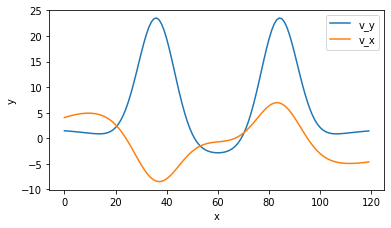

In [2]:
def gaussian(x, x0, sigma, a):
    return a*np.exp(-((x-x0)/sigma)**2)

def vy_profile(x, x1, x2, sigma1, sigma2, a, b):
    return (gaussian(x, x1, sigma1, a) 
            + gaussian(x, x2, sigma1, a)
            + gaussian(x, 60, sigma2, b))

def vx_profile(x, x1, x2, sigma1, a):
    return (gaussian(x, x1, sigma1, -a)
            + gaussian(x, x2, sigma1, a) 
            + gaussian(x, x1-25, sigma1*2, a*0.5) 
            + gaussian(x, x2+25, sigma1*3, -a*0.5))

# Sample profiles
x = np.arange(120)
_, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(vy_profile(x, 36, 84, 10, 40, 25, -5)+2, label=r'v_y')
ax.plot(vx_profile(x, 36, 84, 12, 10), label=r'v_x')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('2')
plt.show()

## Create 2-D velocity fields

Next, we can generate many (60 to be exact for each velocity component) such profiles by modifying the peak locations and amplitudes and then stack all of them together to obtain 2-D fields. For the vertical component $v_y$:

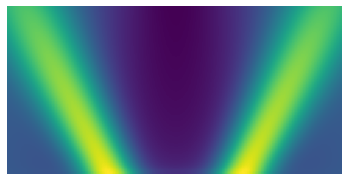

In [3]:
def create_vy(x, c1=36, c2=84, c_adjust=0.5, sig1=10,
              sig1_adjust=0.1, sig2=40, sig2_adjust=-0.2,
              amp1=25, amp1_adjust=-0.2, amp2=-5, amp2_adjust=-1):
    vy = np.zeros((60, 120))
    def mod_log(i):
        out = 0
        if i > 0:
            out = np.log(i)
        else:
            out = 0
        return out

    for i in range(60):
        vy[i, :] = vy_profile(x, c1-i*c_adjust, c2+i*c_adjust,
                              sig1+i*sig1_adjust, sig2 + i*sig2_adjust,
                              amp1 + i*amp1_adjust, amp2 + mod_log(i)*amp2_adjust) + 2
    return vy

# sample
vy = create_vy(x)
plt.imshow(np.flipud(vy))
plt.axis('off')
plt.show()

Similarly for $v_x$:

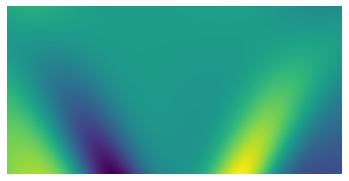

In [4]:
def create_vx(x, c1=36, c2=84, c_adjust=0.5, sig1=12,
              sig1_adjust=0.1, amp1=10, amp1_adjust=-0.2):
    vx = np.zeros((60, 120))

    for i in range(60):
        vx[i, :] = vx_profile(x, c1-i*c_adjust, c2+i*c_adjust,
                            sig1+i*sig1_adjust, 
                            amp1 + i*amp1_adjust)
    return vx

vx = create_vx(x)
plt.imshow(np.flipud(vx))
plt.axis('off')
plt.show()

## Combine with PVC

We can now combine these two components and show the mean flow field using the vector plot as done previously.

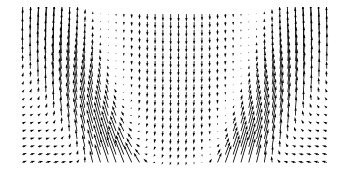

In [5]:
# define the grid
x = np.arange(-2.9, 3.1, 0.05)
y = np.arange(0, 3, 0.05)
X, Y = np.meshgrid(x, y)

# vector plot
_, ax = plt.subplots(1, 1, figsize=(6, 6))
v_x_avg = create_vx(np.arange(120))
v_y_avg = create_vy(np.arange(120))
vskip = 3
ax.quiver(X[::vskip, ::vskip], Y[::vskip, ::vskip], v_x_avg[::vskip, ::vskip],
          v_y_avg[::vskip, ::vskip], units='width', scale=300)
ax.set_aspect('1')
plt.axis('off')
plt.show()

In this 2-D representation, the flow comes from the bottom (e.g., the "inlet" or "nozzle" of the combustor chamber) to the top in the form of tilted "jets" (as indicated by the direction and length of the vectors). In the middle is a so-called recirculation zone, i.e., the flow gets recirculated back from top to bottom. There are two other such recirculations in the bottom left and right corners. 

Now we can add PVC on top of the average fields. For that, we will need to adjust the magnitude of the average fields created here such that the vortices can become visible. It is clear that the PVC vortices can modify the mean flow by "bend" the incoming jets. Try varying the magnitude of PVC relative to the mean fields and see how its manifestation in the flow field changes.

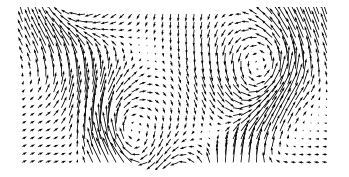

In [6]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))
v_array = pvc_1()
v_x = v_x_avg*0.1 + v_array[0, :]
v_y = v_y_avg*0.1 + v_array[1, :]
vskip = 3
ax.quiver(X[::vskip, ::vskip], Y[::vskip, ::vskip], v_x[::vskip, ::vskip],
          v_y[::vskip, ::vskip], units='width', scale=30)
ax.set_aspect('1')
plt.axis('off')
plt.show()

## Create animation

We can then use animation to visualize the dynamics of PVC on the mean flow. This can be carried out using the following codes:

```python
import matplotlib.animation as animation

f = 470 
fig = plt.figure(frameon=False, figsize=(6, 3.5))
# remove whitespace
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.set_aspect('1')
t = np.arange(8)*1/(8*f)
ims = []
for _t in t:
    v_array = pvc_1()*np.cos(2*np.pi*f*_t) + pvc_2()*np.sin(2*np.pi*f*_t)
    v_x = v_array[0, :] + v_x_avg*0.1
    v_y = v_array[1, :] + v_y_avg*0.1
    vskip = 3
    Q = ax.quiver(X[::vskip, ::vskip], Y[::vskip, ::vskip], v_x[::vskip, ::vskip],
                    v_y[::vskip, ::vskip], units='width', scale=30)
    plt.axis('off')
    ims.append([Q])

ani = animation.ArtistAnimation(fig, ims, interval=150/f*500, blit=True)
ani.save('swirl.gif', dpi=300, writer='imagemagick')
```

This is how the flow pattern looks like:

```{image} ../src/img/swirl.gif
:width: 350px
```



## Conclusions

Isn't the motion somewhat mesmerizing? This "fake" flow field is however not even a close match of what nature has to offer. There are usually complex interactions of multiple dynamics occuring on widely different time scales in real swirling flows. We will look at these more closely in other chapters, where we will use PCA and its variants to carry out pattern recognition on this synthesized flow field.

As mentioned in Part 1, PVC is a 3-D flow structure. In order to reveal its true form, in the following chapter we will see how to perform a 3-D reconstruction of PVC based on the synthesized 2-D fields.
